# Modeling - Insurance App Ratings on Google Play Store

In this notebook, we will
1. select an appropriate __evaluation matrix__
2. devise our __modelling and validation strategy__
3. select the __best model__ and
4. share __actionable business insights__

In [2]:
import pandas as pd
import numpy as np
import time
import string
from datetime import datetime
from pathlib import Path
import re
from scipy.stats import loguniform
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setup Seaborn
plt.style.use('fivethirtyeight')

# For process develpment
development_flag =  False

random_seed = 79

In [118]:
train_review = '../data/interim/train_review.csv'
df_train = pd.read_csv(train_review)
df_train.shape

(7980, 14)

In [119]:
test_review = '../data/interim/test_review.csv'
df_test = pd.read_csv(test_review)
df_test.shape

(2660, 14)

In [120]:
df_train.head()

,reviewId,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,company,year,rating,clean_review,clean_review_len
0,gp:AOqpTOFZYnapoEKajsEGFrCKJ_vmsJ8If4t6mZ5K6xt...,After update my existing policies are not show...,1,0,4.9,2019-10-28 20:49:10,"Hi,\nWe are sorry for the inconvenience caused...",2019-10-29 09:26:51,com.ba.cp.controller,bajaj_allianz,2019,1,update exist policy not show full bug,7
1,gp:AOqpTOHy0QfB7Y5Uj98Kw7F-iRhMZGUeYNw81fR8ZFW...,Tiring. Just keeps icon rotating. Nothing happ...,1,0,7.7,2021-04-10 15:04:07,"Hi Sharad Thombre, We apologize for the inconv...",2021-04-21 10:31:33,com.pms.activity,hdfc_ergo,2021,1,tire keep icon rotate nothing happen wastage time,8
2,gp:AOqpTOGutSpa6ZgezQpU9b58sHejnifKFX_91Qa2SoQ...,"Now it's working properly, thanks",4,0,2.0.17,2021-02-03 15:02:58,"Dear Deepak, thanks for your feedback and we v...",2021-02-04 16:10:40,icici.lombard.ghi,icici_lombard,2021,0,work properly thank,3
3,gp:AOqpTOErT-CbrKgwZlpEKMUBuzlqSlQ5OhR8QOAgA39...,ICICI people ask us to raise the claim through...,1,0,2.0.27,2021-04-14 15:37:37,"Dear Bhushan, we apologize for the inconvenien...",2021-04-14 20:09:17,icici.lombard.ghi,icici_lombard,2021,1,people ask raise claim app app crash continuou...,13
4,gp:AOqpTOE_fRyh1_FEiWVfsG5qCw72bRHskVmI1jwLyNY...,Shaheen explained the app well ..easy to use a...,5,2,2.0.34,2021-06-20 22:18:43,"Dear Ruchika, Thank you so much for your valua...",2021-06-21 19:54:40,icici.lombard.ghi,icici_lombard,2021,0,shaheen explain app well easy use various faci...,12


In [121]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              7980 non-null   object
 1   review                7980 non-null   object
 2   score                 7980 non-null   int64 
 3   thumbsUpCount         7980 non-null   int64 
 4   reviewCreatedVersion  6944 non-null   object
 5   at                    7980 non-null   object
 6   replyContent          6047 non-null   object
 7   repliedAt             6047 non-null   object
 8   appId                 7980 non-null   object
 9   company               7980 non-null   object
 10  year                  7980 non-null   int64 
 11  rating                7980 non-null   int64 
 12  clean_review          7980 non-null   object
 13  clean_review_len      7980 non-null   int64 
dtypes: int64(5), object(9)
memory usage: 872.9+ KB


For modelling purpose, we are mainly intested in ratins, clean review text and comapny column.

In [122]:
df_train = df_train[['rating','clean_review','company']]
df_test = df_train[['rating','clean_review','company']]

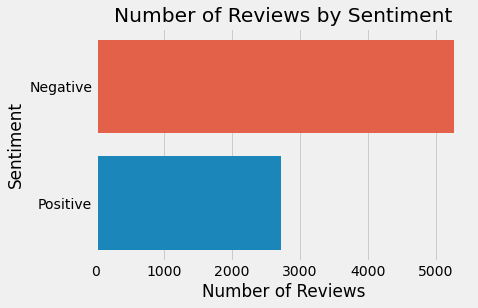

In [123]:
map_sentiment = {0:'Positive', 1:'Negative'}


ax = sns.countplot(y='rating', data= df_train)
ax.set_yticklabels(map_sentiment.values())
ax.invert_yaxis()
plt.ylabel('Sentiment')
plt.xlabel('Number of Reviews')
plt.title('Number of Reviews by Sentiment');

We have 66% negative sentiments and 34% positive sentiments.

## Evaluation matrix

For GI industry, it is important to increase the adaptation and usage of mobile applications. We are more interesting in understanding __what kind of application features or customer services are driving positive or negative sentiments__. We have seen that 40% customers are not happy with the mobile app. This is a huge number. Hence, our __primary focus will be negative sentiment__. Given this business objective, we will be __using the pr_auc__ matrix as it gives more importance to positive class which in our case is negative sentiment.

## Modelling strategy

We are more interested in interpretation and insights. Hence, we consider following algorithms for our classification task. 

### Modelling :

1. __Logistic Regression with l1 regularization__ - Logistic regression is a simple linear algorithm with decent performance. We will use l1 regularization for feature selection. This will also be our base model.
2. __XgBoost__ - XgBoost is known to outperform linear models on tabular data in many cases.
3. __LightGBM__ - LightGBM is faster than XgBoost and tends to perform well on tabular data.

### Feature Extraction : 
For feature extraction from text, we will use CountVectorizer & TfIdf Vectorizer.


### Building Pipeline

We will use company as a feature because we are more interested at industry level issues. With this dummmy, we will control for comapny specific issues. Converting company feature to dummies.

In [124]:
df = pd.get_dummies(df_train['company'],columns = ['company'])
df_train = pd.concat([df_train, df], axis =1)
df_train.shape

(7980, 7)

### Count Vectorizer

Below words do not contain any insights and they are coming as important features in our classification task. Hence, we will remove these words. This will somewhat affect our prediction performance. But we are more interested in interpretation and insights than predictions.

In [125]:
stop_words = ['no','not','nt','even','try','really','within',
              'hello','ever','waste','awesome', 'amazing', 'wrost']

In [133]:
cnt_vec = CountVectorizer(min_df= 20, 
                        stop_words = stop_words,
                        ngram_range=(1,4))


X = cnt_vec.fit_transform(df_train['clean_review'])
df_txt_cv_feat = pd.DataFrame(X.toarray(), columns = cnt_vec.get_feature_names())
df_txt_cv_feat.shape

(7980, 884)

In [134]:
company_ind = True
df_dummy = pd.get_dummies(df_train['company'],columns = ['company'])

if company_ind == True:
    X_train = pd.concat([df_txt_cv_feat, df_dummy], axis =1)
    
else:
    X_train = df_txt_cv_feat
    
X_train.shape

(7980, 888)

In [135]:
y_train = df_train.rating

In [136]:
num_folds = 3
cv = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=random_seed)

In [137]:
classifier_lr = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   random_state=random_seed)

param_dists = { 'C': loguniform(1e-2, 1e2) }

lr_iterations = 30

In [138]:
%%time
cv_lr = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr.fit(X_train, y_train)

Wall time: 2min 18s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                random_state=79, solver='saga',
                                                tol=0.01),
                   n_iter=30, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026896962088>},
                   random_state=79, scoring='average_precision')

In [139]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)
cv_lr_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,14.102494,3.779089,0.054661,0.009158,71.215973,{'C': 71.21597312053972},0.935569,0.957252,0.932533,0.941785,0.011007,1
29,12.265885,2.264678,0.046009,0.008538,86.475666,{'C': 86.47566601912696},0.935562,0.957253,0.932534,0.941783,0.011009,2
28,13.789672,2.545540,0.049733,0.009156,57.112273,{'C': 57.112272826654},0.935566,0.957251,0.932527,0.941781,0.011009,3
25,15.266383,3.644512,0.052556,0.000515,27.662862,{'C': 27.66286224401876},0.935544,0.957235,0.932522,0.941767,0.011007,4
11,13.145710,2.897850,0.042293,0.002058,19.250924,{'C': 19.250924111697937},0.935526,0.957218,0.932503,0.941749,0.011008,5


In [140]:
lr_weights = pd.DataFrame(list(zip(X_train.columns ,
                                   cv_lr.best_estimator_.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 important features for negative reviews

,words,weights
886,hdfc_ergo,0.865906
700,show,0.558576
796,time,0.531221
532,otp,0.460349
818,unable,0.457658
581,poor,0.437050
825,update,0.426735
200,customer,0.426089
717,slow,0.391713
525,open,0.389910


In [141]:
lr_weights.sort_values(['weights'] ).head(15) # top-15 important features for positive reviews

,words,weights
249,easy,-1.231183
784,thank,-0.782605
887,icici_lombard,-0.534095
236,doctor,-0.525512
884,acko,-0.457393
319,friendly,-0.370511
364,helpful,-0.366617
288,fast,-0.365610
613,quick,-0.316421
837,useful,-0.308207


In [142]:
cnt_vec_bi = CountVectorizer(min_df= 20, 
                        stop_words = stop_words,
                        ngram_range=(2,4))

X_bi = cnt_vec_bi.fit_transform(df_train['clean_review'])
df_txt_cv_bi_feat = pd.DataFrame(X_bi.toarray(), columns = cnt_vec_bi.get_feature_names())

if company_ind == True:
    X_train_bi = pd.concat([df_txt_cv_bi_feat, df_dummy], axis =1)
    
else:
    X_train_bi = df_txt_cv_bi_feat
    
X_train_bi.shape


(7980, 289)

In [143]:
%%time
cv_lr = RandomizedSearchCV(classifier_lr, 
                           param_distributions=param_dists, 
                           scoring = 'average_precision',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr.fit(X_train_bi, y_train)

Wall time: 28.4 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                random_state=79, solver='saga',
                                                tol=0.01),
                   n_iter=30, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026896962088>},
                   random_state=79, scoring='average_precision')

In [144]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)
cv_lr_results.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,2.769287,0.584094,0.026784,0.007403,71.215973,{'C': 71.21597312053972},0.866657,0.896624,0.867101,0.876794,0.014023,1
28,2.443298,0.417951,0.017051,0.002502,57.112273,{'C': 57.112272826654},0.866657,0.896617,0.867101,0.876791,0.014020,2
29,2.352331,0.586414,0.023293,0.007837,86.475666,{'C': 86.47566601912696},0.866660,0.896599,0.867099,0.876786,0.014011,3
25,2.732110,0.549098,0.021864,0.001130,27.662862,{'C': 27.66286224401876},0.866648,0.896610,0.867097,0.876785,0.014019,4
11,2.670153,0.612044,0.023108,0.001133,19.250924,{'C': 19.250924111697937},0.866639,0.896584,0.867058,0.876760,0.014019,5


In [145]:
lr_weights = pd.DataFrame(list(zip(X_train_bi.columns ,
                                   cv_lr.best_estimator_.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 important features for negative reviews

,words,weights
287,hdfc_ergo,1.185927
91,customer care,0.716726
275,useless app,0.426778
67,app work,0.394313
6,add policy,0.379310
107,every time,0.328844
150,link policy,0.295555
271,upload document,0.293273
160,many time,0.268944
283,work properly,0.260762


In [146]:
lr_weights.sort_values(['weights'] ).head(15) # top-15 important features for positive reviews

,words,weights
105,easy use,-0.788283
277,user friendly,-0.707227
285,acko,-0.552059
22,app easy,-0.538412
288,icici_lombard,-0.491944
128,hassle free,-0.319141
120,friendly app,-0.279881
231,smile face,-0.273311
56,app thank,-0.238029
99,doctor service,-0.235946


## Tf Idf

In [147]:
tfidf_vec = TfidfVectorizer(stop_words = stop_words,
                            min_df = 20,
                            ngram_range=(1,4),
                            smooth_idf=1,
                            sublinear_tf=1)

X_tfidf = tfidf_vec.fit_transform(df_train['clean_review'])
df_txt_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = tfidf_vec.get_feature_names())
df_txt_tfidf.shape

(7980, 884)

In [148]:
if company_ind == True:
    X_train = pd.concat([df_txt_tfidf, df_dummy], axis =1)
    
else:
    X_train = df_txt_tfidf
    
X_train.shape

(7980, 888)

In [149]:
%%time
cv_lr.fit(X_train, y_train)

Wall time: 49.5 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=79, shuffle=True),
                   estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                random_state=79, solver='saga',
                                                tol=0.01),
                   n_iter=30, n_jobs=-2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026896962088>},
                   random_state=79, scoring='average_precision')

In [150]:
cv_lr_results = pd.DataFrame(cv_lr.cv_results_)
cv_lr_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,4.407541,0.336745,0.039068,0.003047,1.747024,{'C': 1.7470236401254036},0.958407,0.962143,0.964543,0.961698,0.002525,1
10,6.033478,0.214855,0.038007,0.003875,7.02953,{'C': 7.029530209629741},0.958898,0.958685,0.963791,0.960458,0.002358,2
22,4.268866,0.394981,0.038876,0.001136,1.216125,{'C': 1.2161250429807902},0.956361,0.961269,0.962830,0.960153,0.002756,3
15,4.157049,0.401322,0.046477,0.008124,1.147422,{'C': 1.1474217553123074},0.955932,0.961033,0.962516,0.959827,0.002820,4
27,7.065858,1.181264,0.036179,0.006376,10.19941,{'C': 10.199410472959407},0.957733,0.957120,0.963007,0.959287,0.002642,5


In [151]:
lr_weights = pd.DataFrame(list(zip(X_train.columns , # ge tall the n-gram feature names
                                   cv_lr.best_estimator_.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 more important features for positive reviews

,words,weights
581,poor,9.410791
840,useless,7.518782
503,never,7.179928
315,fraud,6.905709
441,load,6.041484
787,third,5.018442
442,loading,4.986108
717,slow,4.785481
446,login,4.745669
602,proper,4.741186


In [152]:
lr_weights.sort_values(['weights']).head(15) # top-15 more important features for positive reviews

,words,weights
249,easy,-11.202260
784,thank,-9.818210
613,quick,-6.845296
236,doctor,-5.655909
102,appreciate,-5.240245
188,convenient,-4.988679
756,superb,-4.508028
455,love,-4.267156
301,fine,-4.261288
278,eye,-4.170779


In [ ]:
df_train.company.unique(), df_train.rating.unique()

In [ ]:
df_train['company_rating'] = df_train['company'].astype('str') + '_' + df_train['rating'].astype('str')
df_train['company_rating'].value_counts()

In [ ]:
lbl_enc = LabelEncoder()

y_train_multiclass = lbl_enc.fit_transform(df_train['company_rating'].values)

In [ ]:
cnt_y = Counter(y_train_multiclass)
cnt_y

In [ ]:
classifier_lr_multi = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   multi_class='multinomial',
                                   random_state=random_seed)

cv_lr_multi = RandomizedSearchCV(classifier_lr_multi, 
                           param_distributions=param_dists, 
                           scoring = 'roc_auc_ovo_weighted',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr_multi.fit(X_train, y_train_multiclass)

In [ ]:
cv_lr_multi_results = pd.DataFrame(cv_lr_multi.cv_results_)
cv_lr_multi_results.sort_values(by='mean_test_score', ascending=False).head()

In [ ]:
lr_weights = pd.DataFrame(list(zip(X_train.columns , # ge tall the n-gram feature names
                                   cv_lr_multi.best_estimator_.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 more important features for positive reviews

In [ ]:
lr_weights.sort_values(['weights']).head(15) # top-15 more important features for positive reviews

In [ ]:
classifier_lr_multi = LogisticRegression(penalty='l1', solver = 'saga', 
                                   max_iter=500, tol = 1e-2, 
                                   multi_class='multinomial',
                                   random_state=random_seed)

cv_lr_multi = RandomizedSearchCV(classifier_lr_multi, 
                           param_distributions=param_dists, 
                           scoring = 'roc_auc_ovr_weighted',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_lr_multi.fit(X_train, y_train_multiclass)

In [ ]:
cv_lr_multi_results = pd.DataFrame(cv_lr_multi.cv_results_)
cv_lr_multi_results.sort_values(by='mean_test_score', ascending=False).head()

In [ ]:
lr_weights = pd.DataFrame(list(zip(X_train.columns , # ge tall the n-gram feature names
                                   cv_lr_multi.best_estimator_.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

lr_weights.sort_values(['weights'], ascending = False).head(15) # top-15 more important features for positive reviews

In [ ]:
lr_weights.sort_values(['weights']).head(15) # top-15 more important features for positive reviews

In [ ]:
df_train.loc[df_train.rating == 0,].company.value_counts()

In [ ]:
df_train.loc[df_train.rating == 1,].company.value_counts()

In [ ]:
bayes_clf = MultinomialNB()

alphas = [.1, 1, 5, 10, 50]

mb_param_dists = { 'alpha': alphas }

mb_iterations = 20

In [ ]:
cv_mb = RandomizedSearchCV(bayes_clf, 
                           param_distributions=mb_param_dists, 
                           scoring = 'roc_auc_ovr_weighted',
                           n_iter=lr_iterations, 
                           cv=cv, 
                           n_jobs= -2,
                           random_state = random_seed)

cv_mb.fit(X_train, y_train_multiclass)

In [ ]:
cv_mb_results = pd.DataFrame(cv_mb.cv_results_)
cv_mb_results.sort_values(by='mean_test_score', ascending=False).head()

In [ ]:
gpu_params = {'tree_method':'gpu_hist', 
              'predictor':'gpu_predictor',
              'n_jobs': -1}

xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', max_delta_step = 1,
                             **gpu_params, use_label_encoder=False, 
                            seed=random_seed, verbosity=0)

xgb_param_dists = {'learning_rate': loguniform(0.001, 1),
               'max_depth' : [4,8,16],
               'min_child_weight' : [4,8],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8],
               'n_estimators' : [200,400,800],
               'reg_alpha' : loguniform(0.001, 10) }

xgb_iterations = 10

In [ ]:
%%time
xgb_cv = RandomizedSearchCV(xgb_clf, 
                           param_distributions=xgb_param_dists, 
                           scoring = 'average_precision',
                           n_iter=xgb_iterations, 
                           cv=cv, 
                           random_state = random_seed)

xgb_cv.fit(X_train, y_train)

In [ ]:
xgb_cv_results = pd.DataFrame(xgb_cv.cv_results_)
xgb_cv_results.sort_values(by='mean_test_score', ascending=False).head()